## Evaluation metrics

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import  roc_auc_score, auc
from sklearn.model_selection import KFold

In [13]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/refs/heads/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv")

Churn adalah istilah bisnis yang merujuk pada pelanggan yang berhenti menggunakan suatu produk atau layanan dalam periode waktu tertentu. Ini bisa terjadi karena berbagai alasan, seperti ketidakpuasan terhadap produk, harga, atau pengalaman pelanggan yang buruk. Tingkat churn (churn rate) adalah metrik penting untuk mengukur persentase pelanggan yang hilang dan memprediksi pertumbuhan bisnis. 

### Cleaning data

In [15]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
cat_col = df.dtypes[df.dtypes == "object"].index.tolist()
for col in cat_col:
    df[col] = df[col].str.lower().str.replace(" ", "_")

### Handle missing values

In [16]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)
df.churn = (df.churn == 'yes').astype(int)

### Setup validation framework

In [132]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train["churn"]
del df_val["churn"] 
del df_test["churn"]

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

### One-hot encoding

In [18]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [19]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8026969481902059

## Accuracy and Dummy Model

- evaluate the model on different thresholds
- check the accuracy of a dummy baselines

In [20]:
len(y_val)

1409

In [22]:
# how many correct predictions are correct
(y_val == churn_decision).sum()

1131

In [23]:
# so the accuracy is 
1131 / 1409

0.8026969481902059

In [24]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [29]:
scores = []
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.592
0.15 0.667
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


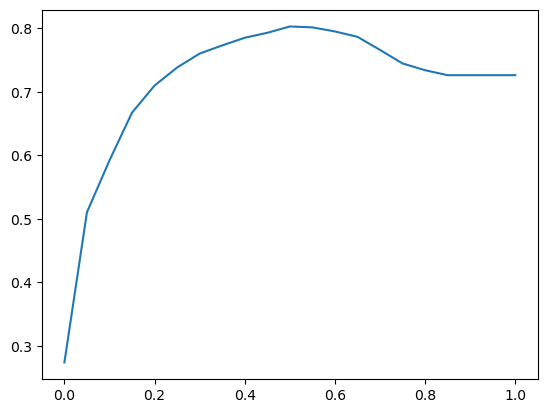

In [26]:
plt.plot(thresholds, scores)

In [ ]:
# basically the same as
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8026969481902059

In [31]:
# so we can
scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.592
0.15 0.667
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [32]:
from collections import Counter
Counter(y_pred >= 1.0)

Counter({False: 1409})

so it means predicts for every customer that they will not churn.

our model accuracy is 80%, while the dummy model accuracy is 74%, so the problem is in accuracy

let'see the distribution of our `y_val`

In [33]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [34]:
y_val.mean()

0.2739531582682754

there are alot more non-churned customers than churned ones. 27% are churning. This is called class imbalance.

##  Confusion table

- different types of errors and correct decisions
- arranging them in a table

In [35]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [36]:
predict_positive[:5]

array([False, False, False,  True, False])

In [37]:
actual_positive[:5]

array([False, False, False,  True, False])

In [39]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [40]:
fp, fn

(102, 176)

In [41]:
confusion_matrix = np.array(
    [[tn, fp],
    [fn, tp]]
)
confusion_matrix

array([[921, 102],
       [176, 210]])

So 25% of the customers would be sent an email about churing

In [43]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision and Recall

Precision is how many fraction of the predicted churned customers actually churned. So the formula is TP / (TP + FP). TP / Positive Predictions.

Recall is how many fraction of the actual churned customers were predicted correctly. So the formula is TP / (TP + FN). TP / Positive Observations.

In [45]:
p = tp / (tp + fp)
p

0.6730769230769231

In [46]:
r = tp / (tp + fn)
r

0.5440414507772021

In [44]:
(tp + tn) / (tp + tn + fp + fn)

0.8026969481902059

Precision and Recall are useful when dealing with imbalanced datasets, where one class is significantly more prevalent than the other. In such cases, **accuracy can be misleading**, as a model that predicts the majority class for all instances can still achieve high accuracy. Precision and Recall provide a more nuanced view of the model's performance by focusing on the minority class (e.g., churned customers) and evaluating how well the model identifies those instances.

## ROC Curve and AUC

This is the way of describing the performance of a classification model at all classification thresholds. It is a plot of the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

### FPR and TPR

We want to minimize false positive rate and maximize true positive rate. The ideal point is (0, 1) which means no false positives and all true positives.

In [49]:
tpr = tp / (tp + fn) # same as recall
tpr

0.5440414507772021

In [48]:
fpr = fp / (fp + tn)
fpr

0.09970674486803519

In [53]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [54]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,555,20,468
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,102,176,921
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,2,373,1021
90,0.9,0,0,386,1023


In [ ]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (865329605.py, line 1)

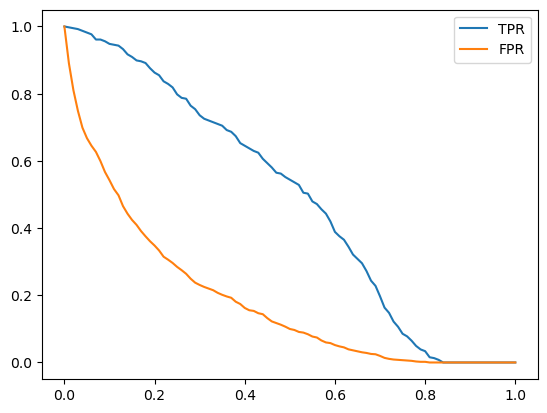

In [59]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

### Random model

In [61]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [63]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [64]:
def tpr_fpr_df(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [65]:
df_rand = tpr_fpr_df(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


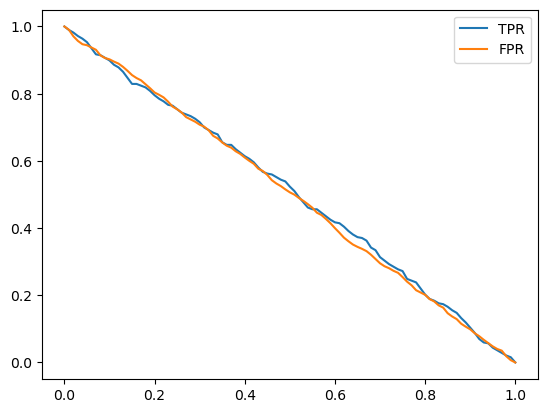

In [66]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()

### Ideal model

We are using the threshold about 0.72 so we have TPR almost 1 and FPR almost 0.

In [67]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [68]:
y_ideal = np.repeat([0, 1], repeats=[num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [69]:
1 - y_val.mean()

0.7260468417317246

In [70]:
y_ideal_pred = np.linspace(0, 1, len(y_val))
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

so in this predict we have the accurate theshold for the ideal model

In [71]:
df_ideal = tpr_fpr_df(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


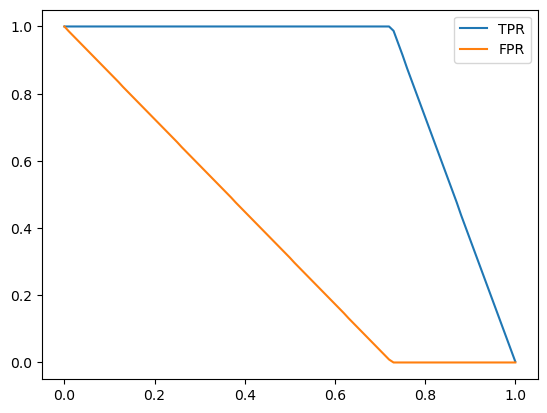

In [78]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

this model can identify all churned customers while minimizing false positives, it simply because we cutting at the right threshold.

### Putting everything together

In [ ]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

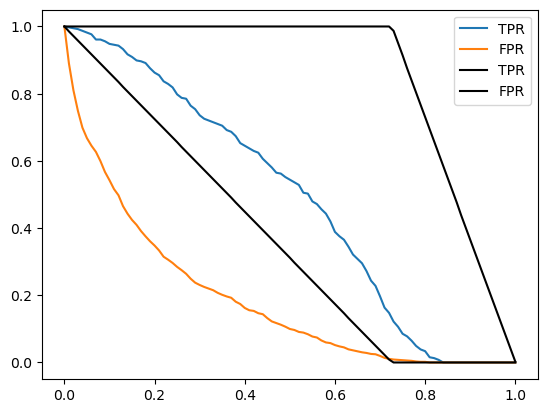

In [76]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

# plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
# plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='black')
plt.legend()

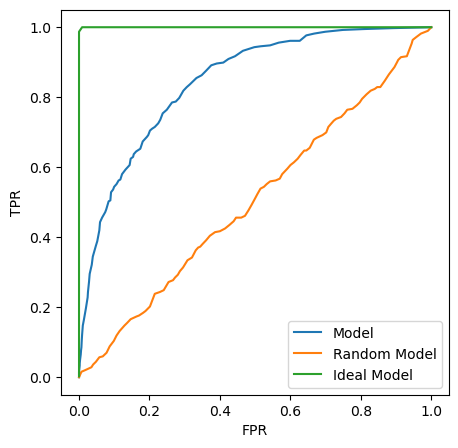

In [82]:
plt.figure(figsize=(5, 5))
plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random Model')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal Model')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

we want our curve to be as close as possible to the ideal model curve. so we plot

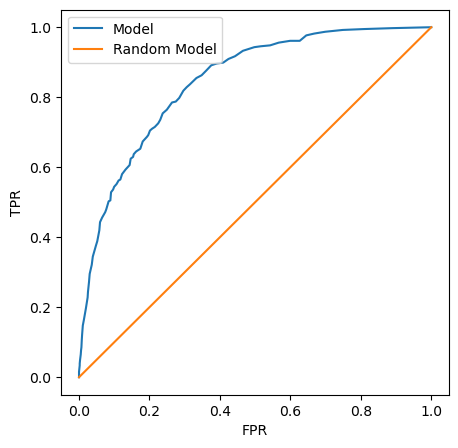

In [83]:
plt.figure(figsize=(5, 5))
plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0,1], [0,1], label='Random Model')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### Area Under the Curve (AUC)

- area under the ROC curve - useful metric
- interpreting AUC

In [84]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_val, y_pred)

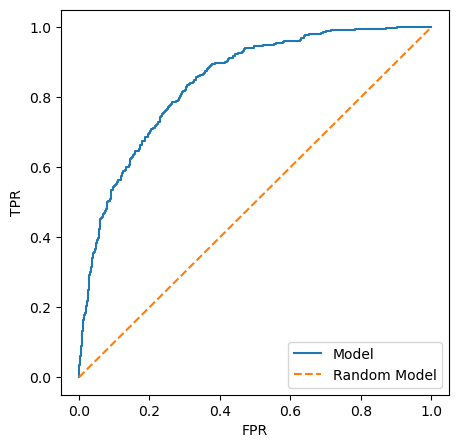

In [86]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random Model', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [87]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.8438834272864023

In [88]:
auc(df_scores.fpr, df_scores.tpr)

0.8437378126915149

In [89]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [92]:
fpr, tpr, threshold = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438834272864023

In [91]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8438834272864023

AUC is the probability that a randomly chosen positive instance (churned customer) is ranked higher by the model than a randomly chosen negative instance (non-churned customer).

In [93]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [95]:
import random

n = 100000
success = 0

for i in range(n):
    neg_ind = random.randint(0, len(neg) - 1)
    pos_ind = random.randint(0, len(pos) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.84246

In [100]:
n = 50000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84392

## Cross Validation

- evaluating the same model on different subsets of data
- getting the average prediction and the spread within predictions

In [136]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [102]:
dv, model = train(df_train, y_train)

c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [105]:
y_pred = predict(df_val, dv, model)

In [106]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
kfold.split(df_full_train)

<generator object _BaseKFold.split at 0x0000018C16666020>

In [ ]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [109]:
len(train_idx), len(val_idx)

(5070, 564)

In [110]:
len(df_full_train)

5634

In [118]:
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(df_val.churn.values, y_pred)
        scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.841 +- 0.012


In [112]:
from tqdm.auto import tqdm

In [125]:
n_splits = 5
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(df_val.churn.values, y_pred)
        scores.append(auc)
        
    print('C=%.3f %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

C=0.001 0.842 +- 0.007


c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

C=0.010 0.842 +- 0.007


c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

C=0.100 0.842 +- 0.007


c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

C=0.500 0.842 +- 0.007


c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

C=1.000 0.842 +- 0.007


c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

C=5.000 0.842 +- 0.007


c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

C=10.000 0.842 +- 0.007


c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [126]:
scores

[0.8444591847147758,
 0.8451550291352139,
 0.8333172787477424,
 0.8347928790688751,
 0.8517853220796334]

In [137]:
dv, model = train(df_full_train, df_full_train.churn.values, C=0.01)
y_pred = predict(df_test, dv, model)
roc_auc_score(y_test, y_pred)

c:\Users\anugraha\miniconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8548688073493884

## Summary

- Metric - a single number that describes model performance
- Accuracy - fraction of correct predictions; sometimes misleading
- precision and recall are less misleading when we have class imbalance
- ROC curve - a way to evaluate model performance at all thresholds; okay to use with imbalance
- K-fold cross-validation - more reliable estimate of model performance (mean + std)

## Explore more

- check the precision and recall of the dummy classifier that always predicts "FALSE"
- F1 score = 2 * (precision * recall) / (precision + recall)
- evaluate precision and recall at different thresholds, plot precision vs recall - this way you'll get the precision/recall curve (similar to ROC curve)
- area under the PR curve is also a useful metric